In [21]:
import sys
import glob
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pytz
%matplotlib inline

In [22]:
tz = pytz.timezone('America/Denver')

In [52]:
def get_start_split_trace():
    events = []
    for line in open('bs11/ceph-osd.0.log'):
        parts = line.split()
        if len(parts) > 5 and parts[4] == "start_split":
            date = parts[0]
            time = parts[1].split(".")[0]
            dtstr = date + " " + time
            d = dt.datetime.strptime(dtstr, "%Y-%m-%d %H:%M:%S")
            events.append(d)
    return events

def get_finish_split_trace():
    events = []
    for line in open('bs11/ceph-osd.0.log'):
        parts = line.split()
        if len(parts) > 5 and parts[4] == "complete_split":
            date = parts[0]
            time = parts[1].split(".")[0]
            dtstr = date + " " + time
            d = dt.datetime.strptime(dtstr, "%Y-%m-%d %H:%M:%S")
            events.append(d)
    return events

In [58]:
def get_client_tp_trace():
    times = []
    rates = []
    for line in open('bs11/client.log'):
        parts = line.split()
        assert len(parts) == 5
        seconds = long(parts[2])
        rate = long(parts[3].split("=")[1])
        d = datetime.datetime.fromtimestamp(seconds, tz).replace(tzinfo=None)
        times.append(d)
        rates.append(rate)
        
    trace = pd.DataFrame({'time': times, 'iops': rates})
    
    ### order like a time series by the completion time of the I/O
    trace.sort_values(by='time', ascending=True, inplace=True)
    return trace

In [61]:
client_trace = get_client_tp_trace()
print client_trace.head()

df = pd.DataFrame({'split_start': get_start_split_trace(), 'split_end': get_finish_split_trace()})
df['y1'] = np.random.randint(19000, 21000, len(df.split_start))
df['y2'] = np.random.randint(21500, 23500, len(df.split_start))
df.sort_values(by='split_start', ascending=True, inplace=True)
df.head()

    iops                time
0  21120 2016-04-28 18:58:25
1  12742 2016-04-28 18:58:27
2  20842 2016-04-28 18:58:29
3  18579 2016-04-28 18:58:31
4  12618 2016-04-28 18:58:33


,split_end,split_start,y1,y2
0,2016-04-28 18:59:06,2016-04-28 18:59:05,20443,21666
1,2016-04-28 18:59:06,2016-04-28 18:59:06,19473,22925
2,2016-04-28 18:59:06,2016-04-28 18:59:06,19470,22736
3,2016-04-28 18:59:06,2016-04-28 18:59:06,20428,21619
4,2016-04-28 18:59:07,2016-04-28 18:59:06,19001,21680


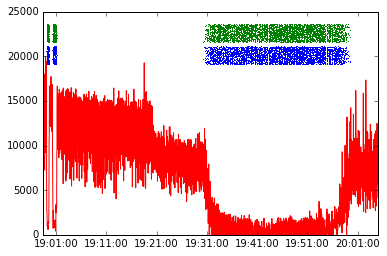

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df.split_start, df.y1, label='a', marker=',', linestyle='')
ax.plot(df.split_end, df.y2, label='b', marker=',', linestyle='')
ax.plot(client_trace.time, client_trace.iops)
plt.savefig('x.png', dpi=300, bbox_inches='tight')